# K-Nearest Neighbors Regression Model

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [20]:
# Load the dataset
df = pd.read_excel('Oneven_Turbidity_with_Weather.xlsx', index_col='Date', parse_dates=True)
df = df.asfreq('H')
df = df.rename(columns={'Oneven Turbidity': 'y'})

C:\Users\Yin Jianing\AppData\Local\Temp\ipykernel_51448\3594112708.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.asfreq('H')


In [21]:
df.index

DatetimeIndex(['2021-01-05 15:00:00', '2021-01-05 16:00:00',
               '2021-01-05 17:00:00', '2021-01-05 18:00:00',
               '2021-01-05 19:00:00', '2021-01-05 20:00:00',
               '2021-01-05 21:00:00', '2021-01-05 22:00:00',
               '2021-01-05 23:00:00', '2021-01-06 00:00:00',
               ...
               '2023-12-30 00:00:00', '2023-12-30 01:00:00',
               '2023-12-30 02:00:00', '2023-12-30 03:00:00',
               '2023-12-30 04:00:00', '2023-12-30 05:00:00',
               '2023-12-30 06:00:00', '2023-12-30 07:00:00',
               '2023-12-30 08:00:00', '2023-12-30 09:00:00'],
              dtype='datetime64[ns]', name='Date', length=26131, freq='h')

In [22]:
df.columns

Index(['y', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'precipitation (mm)', 'soil_temperature_0_to_7cm (°C)',
       'soil_moisture_0_to_7cm (m³/m³)', 'wind_speed_10m (km/h)',
       'wind_gusts_10m (km/h)', 'precipitation (mm) Lag96',
       'soil_temperature_0_to_7cm (°C) Lag120',
       'soil_moisture_0_to_7cm (m³/m³) Lag120'],
      dtype='object')

In [23]:
df.dtypes

y                                        float64
temperature_2m (°C)                      float64
relative_humidity_2m (%)                   int64
precipitation (mm)                       float64
soil_temperature_0_to_7cm (°C)           float64
soil_moisture_0_to_7cm (m³/m³)           float64
wind_speed_10m (km/h)                    float64
wind_gusts_10m (km/h)                    float64
precipitation (mm) Lag96                 float64
soil_temperature_0_to_7cm (°C) Lag120    float64
soil_moisture_0_to_7cm (m³/m³) Lag120    float64
dtype: object

In [24]:
# Define features (X) and target (y)
X = df.drop(columns=['y'])
y = df['y']

In [25]:
# Split into train and test sets
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [27]:
# Parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25],
}
knn = KNeighborsRegressor()



In [28]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
# grid search with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=tscv, scoring='neg_mean_squared_error')


In [30]:
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25]},
             scoring='neg_mean_squared_error')

In [31]:
# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation MSE: {-grid_search.best_score_}")


Best parameters: {'n_neighbors': 25}
Best cross-validation MSE: 3.8389069754669842


In [32]:
# Predict on train, and test sets 
best_knn = grid_search.best_estimator_
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

In [33]:
# calculate evaluation metrics for test set
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print evaluation metrics
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}")
print(f"Test MAPE: {test_mape:.4f}")


Test MAE: 1.5590
Test MSE: 4.3407
Test RMSE: 2.0834
Test R^2: -0.0751
Test MAPE: 0.9726


In [34]:
# calculate evaluation metrics for train set
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
# print evaluation metrics for training set
print(f"Training Set Mean Absolute Error: {train_mae:.4f}")
print(f"Training Set Mean Squared Error: {train_mse:.4f}")
print(f"Training Set Root Mean Squared Error: {train_rmse:.4f}")
print(f"Training Set R^2 Score: {train_r2:.4f}")
print(f"Training Set Mean Absolute Percentage Error: {train_mape:.4f}")



Training Set Mean Absolute Error: 0.7650
Training Set Mean Squared Error: 1.4329
Training Set Root Mean Squared Error: 1.1971
Training Set R^2 Score: 0.5487
Training Set Mean Absolute Percentage Error: 901519486910.7448


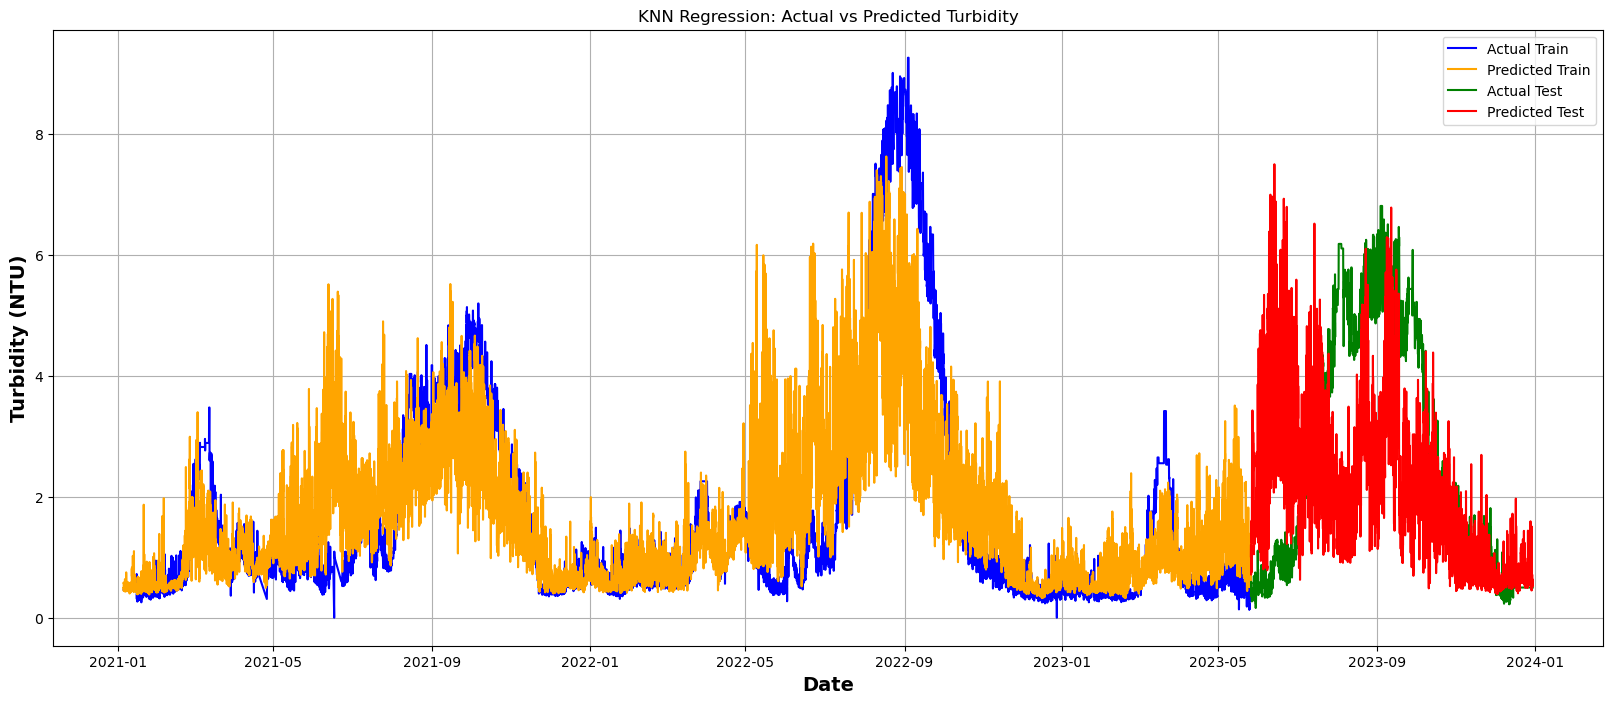

In [37]:
# PLot predictions vs actual values for training and test sets
plt.figure(figsize=(20, 8))
plt.plot(y_train.index, y_train, label='Actual Train', color='blue')
plt.plot(y_train.index, y_train_pred, label='Predicted Train', color='orange')
plt.plot(y_test.index, y_test, label='Actual Test', color='green')
plt.plot(y_test.index, y_test_pred, label='Predicted Test', color='red')
plt.title('KNN Regression: Actual vs Predicted Turbidity')
plt.xlabel('Date', fontsize=14, fontweight='bold')
plt.ylabel('Turbidity (NTU)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid()
plt.show()


